In [1]:
import astroprov
from astropy.io import fits
from astropy.table import Table
from astropy.io import ascii
from astropy.stats import sigma_clipped_stats
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt
import numpy as np
import os
import subprocess
import time


In [2]:
#standardStarsXY = [[848.34847, 732.44864],[809.3484, 769.44864],[794.35,885.45]]

In [3]:
FWHM = 5.0
MinSep = 0.8 #sets value for discriminating sources
#N = len(Image) #number of images minus 1 as it starts from zero
imno = 0
imagedata = []
sources = dict()
Date = []
STD = []
Median = []

In [4]:
imageRefernce = '/home/mj1e16/moleGazer/Photos/F/29018.jpg'
imageAlign =  '/home/mj1e16/moleGazer/Photos/F/79948.jpg'

## max setting [6.444444444444445, 21.842105263157894, 'gauss_5.0_9x9.conv']

alignTab = Table.read('/home/mj1e16/moleGazer/Photos/F/fitsImages/simMolePos/79948InvertedAverageCropped166.44444444444_21.8421052632_gauss_5.0_9x9.conv.cat',format='ascii.sextractor')
refTab = Table.read('/home/mj1e16/moleGazer/Photos/F/fitsImages/simMolePos/29018InvertedAverageCropped166.44444444444_21.8421052632_gauss_5.0_9x9.conv.cat',format='ascii.sextractor')

In [5]:
def makeDS9RegFile(sexTabList,fileNameBase,tabType,colour='red',radius='10'):
    for tables in range(len(sexTabList)):
        if tabType == 'dao':
            xcoords = sexTabList[tables]['xcentroid']
            ycoords = sexTabList[tables]['ycentroid']
        elif tabType == 'sexMedian':
            ra = sexTabList[tables]['RA']
            dec = sexTabList[tables]['DEC']
        elif tabType == 'sex':
            xcoords = sexTabList[tables]['X_IMAGE']
            ycoords = sexTabList[tables]['Y_IMAGE']
        elif tabType == 'iraf':
            xcoords = sexTabList[tables]['X_POS']
            ycoords = sexTabList[tables]['Y_POS']        
        else:
            print('tab type error')
            break
        bigString = 'image\n'
        for x in range(len(xcoords)):
            bigString += 'circle({},{},'.format(xcoords[x],ycoords[x])+radius+') # color={}\n'.format(colour)
        fileName = fileNameBase + '.reg'
        with open(fileName,'w') as f:
            f.write(bigString)
            
    return fileName

In [6]:
makeDS9RegFile([alignTab],'/home/mj1e16/moleGazer/MoleGazer/79948Regions','sex')
makeDS9RegFile([refTab],'/home/mj1e16/moleGazer/MoleGazer/29018Regions','sex')

'/home/mj1e16/moleGazer/MoleGazer/29018Regions.reg'

In [7]:
fullDistances[0][-1]

NameError: name 'fullDistances' is not defined

In [8]:
sources[0] = refTab
sources[1] = refTab

In [44]:
sources

{0: <Table length=53>
 NUMBER MAG_BEST FLUX_MAX X_IMAGE   Y_IMAGE  ELONGATION ELLIPTICITY
          mag       ct      pix       pix                          
 int64  float64  float64  float64   float64   float64     float64  
 ------ -------- -------- -------- --------- ---------- -----------
      1 -14.2535  90.4865 973.6845  703.1457       3.64       0.725
      2 -16.1422 131.6053 928.9851  124.8221      9.904       0.899
      3 -14.7268 131.2113 338.9145  130.8064      1.306       0.234
      4 -13.0731 68.59529 502.5219  474.6656      3.099       0.677
      5 -13.6935 87.83372 970.7584  584.3197      3.807       0.737
      6 -13.8974 82.99835 509.9209  877.8651      5.954       0.832
      7 -12.0084 60.87981 1031.917  403.2992      2.469       0.595
      8 -10.1475 43.76622 652.4357  497.0686      1.488       0.328
      9 -13.7281 88.40231 445.6149 1268.4027      4.962       0.798
    ...      ...      ...      ...       ...        ...         ...
     44  -9.6286 43.92213 

In [10]:
# sources = {}

# for x in range(N):
#     output = daoStarFinder(x)
#     sources[x] = output[0]
#     Date[x] = output[1]
#     imagedata[x] = output[2]
# os.chdir(bindingsdirectory) 

In [11]:
# could use a re-work

def findTestSources(sources,lowx, highx, lowy, highy, imageNo):
    """
    Searches for bright objects to be used for pattern recognition within a specified region of the reference image.

    :param sources: Table of object data
    :param lowx: Lower X limit of for searching region region
    :param highx: Upper X limit
    :param lowy: Lower Y limit
    :param highy: Upper Y limit
    :param imageNo: Reference image number
    :return: Indexes in sources of (up to) the brightest 15 objects contained within the specified region
    """
    testsources = {}
    mag = []
    number = []
    #for x in range(sources[imageNo][-1][0]):
    for x in range(len(sources[imageNo])):
        x1 = sources[imageNo]['X_IMAGE'][x]
        y1 = sources[imageNo]['Y_IMAGE'][x]
        if x1 > lowx and x1 < highx and y1 > lowy and y1 < highy:
            testsources[x] = sources[imageNo][x]
            mag.append(sources[imageNo]['MAG_BEST'][x])
            number.append(x)
    Z2 = [x for _,x in sorted(zip(mag,number))]
    samplestars = Z2[0:15]
    
    #astroprov.provcall([sources,lowx, highx, lowy, highy, imageNo],[samplestars],"findTestSources_PythonCode2PythonCode_SQ_tmpl.provn","findTestSources")
    return samplestars

In [12]:
samples = findTestSources(sources,0,10000,0,10000,0)

In [13]:
samples1 =  findTestSources(sources,0,10000,0,10000,1)

In [14]:
def distance(sources,object1,object2,imageNo):
    """
    Find the distance between two objects in an image.

    :param sources: Table of object data
    :param object1: Index of first object in sources
    :param object2: Index of second object in sources
    :param imageNo: Image Number
    :return: Diagonal distance between the two objects
    """
 
    return (((abs(sources[imageNo]['X_IMAGE'][object1]-sources[imageNo]['X_IMAGE'][object2])**2) + (abs(sources[imageNo]['Y_IMAGE'][object1]-sources[imageNo]['Y_IMAGE'][object2])**2))**0.5)


In [15]:
def referenceDistances(sources,samplestars,imageNo):
    """
    Calculate the diagonal distance between every object in samplestars.

    :param sources: Table of object data
    :param samplestars: List containing the indexs of stars
    :param imageNo: reference image number
    :return: List containing a list for each object, comprised of the diagonal distance between that object and every object in samplestars
    """
    #referencedistances = [[]]*len(samplestars)
    referencedistances = [[] for x in samplestars]
    for y in range(len(samplestars)):
        refd = []
        for x in range(len(samplestars)):
            refd.append(distance(sources,samplestars[y],samplestars[x],imageNo))
        referencedistances[y] = refd #.append(distance(sources,samplestars[y],samplestars[x],imageNo))
    
    #astroprov.provcall([sources,samplestars,imageNo],[referencedistances],"referenceDistances_PythonCode2PythonCode_SQ_tmpl.provn","referenceDistances")
    return referencedistances


In [16]:
def findFullDistances(sources,imageno):
    """
    Find the diagonal distances between every object in the image.

    :param sources: Table of object data
    :param imageno: Image number
    :return: Digonal distance between every object in the image
    """

    a=[]
    fulldistances = []
    for x in range(len(sources[imageno])):
        if x != 0:    
            fulldistances.append(a)
            a = []
        for y in range(len(sources[imageno])):
            a.append(distance(sources,x,y,imageno)) 
    
    #astroprov.provcall([sources,imageno],[fulldistances],"findFullDistances_PythonCode2PythonCode_SQ_tmpl.provn","findFullDistances")
    return fulldistances

In [17]:
def solveObjects(closeness,fd,samplestars,refd,imageNumber):
    """
    Match the reference distances for the sample stars to the full distances in the image
    and determine which objects could be potential matches.

    :param closeness: Tollerence for pixel locations from image to image
    :param fd: Full distance set per image
    :param samplestars: Indexes of reference objects
    :param refd: Distances between all reference objects
    :param imageNumber: Image number
    :return: Large mess of all objects that are potentially on of the reference objects
    """

    othernew = [[] for x in fd]
    othermess = []
    messaroni = []
    for y in range(len(fd)): #loop over all objects in image
        temp = []
        tempmess = []
        for z in range(len(refd)): # loop for all distances
            bigmess = []
            for x in range(len(refd[z])): # loops over all distances for each target object
                newlist = [i for i, t in enumerate(fd[y]) if abs(t - refd[z][x]) <= closeness] # subtract diatance of object from that of the reference object
                if len(newlist) != 0:
                    bigmess.extend(newlist)
            temp.extend(bigmess)
            tempmess.append(bigmess)
        if len(tempmess) != 0:
            messaroni.append(temp)
    
    #astroprov.provcall([closeness,fd,samplestars,refd,imageNumber],[messaroni],"solveObjects_PythonCode2PythonCode_SQ_tmpl.provn","solveObjects")
    return messaroni

In [32]:
def matchUp(potList,sampleStars): # potList is list of potential stars
    """
    Allocate potential matches found in solveObjects to objects within sampleStars.

    :param potList: List of objects that are potentially the reference objects
    :param sampleStars: Reference object indexes
    :return: List of potential objects ordered in the same way as sampleStars
    """
    zeros = {}
    matchTime = 0
    setTime = 0
    zerosTime = 0
    for y in range(len(potList)+1): # set up counter
        zeros[y] = 0
    for x in range(len(potList)):
        for y in range(len(potList)):
            #if x != y:

            potListx = list(set(potList[x]))
            potListy = list(set(potList[y]))
            match = [i for i in potListx if i in potListy] 
            match = list(set(match))
            for matchCycle in match:
                zeros[matchCycle] += 1 # find occurence of each object

    maxDict = {key: zeros[key] for key in sorted(zeros, key=zeros.get, reverse=True)[:int(len(potList)-1)]} # top star matches
    stars = []
    for x in (maxDict):
        stars.append(x)
    full = []
    for x in stars:
        if x != len(potList):
            check = [i for i in potList[x] if i != x and i in stars]
            check = list(set(check))
            full.append(check)
    final = {}
    for x in range(len(full)): # loop referencing occurence of best matches for other matches
        for y in range(len(full[x])):
            try:
                final[full[x][y]] += 1
            except:
                final[full[x][y]] = 0
    
    

    maxDict = {key: final[key] for key in sorted(final, key=final.get, reverse=True)[:(len(final))]} # rturn top matched
    finalMatch = sorted(maxDict)
    
    #astroprov.provcall([potList,sampleStars],[finalMatch],"matchUp_PythonCode2PythonCode_SQ_tmpl.provn","matchUp")
    return finalMatch

In [52]:
def crossReference(refd, refmatch, sampleStars, matched, closeness, sources, imagenumber):
    """
    Finds the best potential matches for each standard star by analysing how many distances each object has in
    common with the corresponding reference object and then uses circles to determine whethter the x and y positions are
    also close. Note, only diagonals and circles are used to recognise target objects as they are rotationally invariant
    and the image orientation can vary.

    :param refd: Full distances per image
    :param refmatch: Distance between reference objects
    :param sampleStars: Reference objects
    :param matched: Potential reference objects within target image
    :param closeness: Pixel tollerence between images
    :param sources: Table of object data
    :param imagenumber: target image number
    :return: List of reference objects in target image which are very good fits
    """
    #subcheck = []
    lengths = [[]] * len(refd)
    for x in range(len(refd)):
        temp = []
        for y in range(len(refmatch)):
            tot = []
            for xx in range(len(refd[x])):
                subtraction = [abs(refd[x][xx] - Distance) for Distance in refmatch[y] if abs(refd[x][xx] - Distance) <= closeness]
                if len(subtraction) != 0:
                    tot.append(subtraction)
                    print('yay x {} xx {} y{}'.format(x,xx,y))
#                 else:
#                     print('len(subtraction) = 0 for pos x_{}_{}, y_{}'.format(x,xx,y))
            temp.append(len(tot))
        lengths[x] = temp  # .append(len(tot))
    orderedList = []
    for x in range(len(lengths)):
        maximo = max(lengths[x])
        pos = [i for i, d in enumerate(lengths[x]) if d == maximo]
        orderedList.append([matched[position] for position in pos])

    circularMatchedList = findSampleCircles(sources, orderedList, refd, imagenumber, closeness)
    
    
    #astroprov.provcall([refd, refmatch, sampleStars, matched, closeness, sources, imagenumber], [circularMatchedList], "crossReference_PythonCode2PythonCode_SQ_tmpl.provn", "crossReference")
    return [circularMatchedList[0],pos,circularMatchedList[1]]


In [59]:
def findSampleCircles(sources,orderedList,refd,imagenumber,closeness):
    """
    Draws circles around objects that are potentially contained in sampleStars for that image, using their position and
    relative distance to other objects in sampleStars. The circle points are then compared to the positions of objects in
    sampleStars to determine the best fit objects for the reference objects in the target image.

    :param sources: Table of object data
    :param orderedList: Potential list of sample stars in this image
    :param refd: Full distances for every object in this image
    :param imagenumber: Image number
    :param closeness: Tollerance for pixel value between images
    :return: Best fit list of sample stars for this image
    """
    radians = np.linspace(0.,2*np.pi,500)
    #closeness = 3
    matches = [[] for counter in orderedList]
    allCircles = []
    for objects in range(len(orderedList)): # removed 1, from loop
        positions = []
        objectMatches = [[] for counter in orderedList[0]]
        for x in range(len(orderedList[0])):
            coords = []
            coords.append(sources[imagenumber]['X_IMAGE'][orderedList[0][x]])
            coords.append(sources[imagenumber]['Y_IMAGE'][orderedList[0][x]])
            positions.append(coords)
        ## xrb distances must be ordered
        circles = []
        for x in range(len(positions)):
            circlePoints = []
            for y in range(len(radians)):
                cirCoords = []

                cirCoords.append(positions[x][0]+(refd[0][objects]*np.cos(radians[y])))
                cirCoords.append(positions[x][1]+(refd[0][objects]*np.sin(radians[y])))
                circlePoints.append(cirCoords)
#                 if y%20 ==0:
#                     plt.plot(cirCoords[0],cirCoords[1],'o',markersize=0.5)
            circles.append(circlePoints)

        referencePositionX = [sources[imagenumber]['X_IMAGE'][potench] for potench in orderedList[objects]]
        referencePositionY = [sources[imagenumber]['Y_IMAGE'][potench] for potench in orderedList[objects]]
#         plt.plot(referencePositionX,referencePositionY,'ko')
#         plt.show()
        totPositionSpeartion = []
        
        looseMatch = [[] for counter in circles]

        for x in range(len(circles)):
            matchPerCirc = []
            positionSeparation = [[] for counter in referencePositionX]
            #positionSeparation = [[]]*len(referencePositionX)
            for z in range(len(referencePositionX)):
                positionSeparationPerCandidate = []
                for y in range(len(circles[x])):
                    xsep = abs(referencePositionX[z] - circles[x][y][0]) 
                    ysep = abs(referencePositionY[z] - circles[x][y][1]) 
                    positionSeparationPerCandidate.append((xsep**2 + ysep**2)**0.5)
                positionSeparation[z] = positionSeparationPerCandidate
            minVal = []
            for cycle in range(len(positionSeparation)):
                minVal.append(min(positionSeparation[cycle]))
            trueMin = min(minVal)
            trueMatchPos = minVal.index(trueMin)

            if trueMin < closeness:
                matchPerCirc.append(orderedList[objects][trueMatchPos])
            objectMatches[x] = matchPerCirc
        matches[objects] = objectMatches
        allCircles.append(circles)
    
    #astroprov.provcall([sources,orderedList,refd,imagenumber,closeness],[matches],"crossReference_PythonCode2PythonCode_SQ_tmpl.provn","findSampleCircles")
    return [matches,allCircles]

In [35]:
def finalMatch(matches,sampleStars,sources,imagenumber,refImageNo):
    """
    Find how many macthes each of the potential sample star have with each other and generate the final best list for sample stars.

    :param matches: Current best matched list
    :param sampleStars: Reference star indexes in reference image
    :param sources: Table of object data
    :param imagenumber: Referece image number
    :param refImageNo: Target image number
    :return: Final list of sample stars in target image
    """
    zeros = [0]*len(matches[1])
    for x in range(len(matches)):
        for y in range(len(matches[x])):
            zeros[y] += len(matches[x][y])
    maximo = max(zeros)
    bestfits = [i for i,x in enumerate(zeros) if x ==maximo]

    answers = []
    answerDict = {}
    for x in bestfits:
        bestlist = []
        for y in range(1,len(matches)):
            if len(matches[y][x]) != 0:
                bestlist.append(matches[y][x][0])
                answerDict[y] = matches[y][x][0]
        answers.append(bestlist)
#     print('answerDict', answerDict)
#     print('answers',answers)
    for x in range(len(answers)):
        for y in range(len(answers)):
            if answers[x] != answers[y]:
                print('Two Potential Matches')
            finalMatch = answers[0]
    #print(answers,'- answers')       
    ## graphs that prove the matches
#     for x in range(1,len(sampleStars)):
#         plt.plot(sources[refImageNo][sampleStars[x]][1],sources[refImageNo][sampleStars[x]][2],'ro')
#     plt.show()
#     for x in range(len(finalMatch)):
#         plt.plot(sources[imagenumber][finalMatch[x]][1],sources[imagenumber][finalMatch[x]][2],'ko')
#     plt.show()
    #print(finalMatch, 'finalMatch')
    finalAnswer = {}
    finalAnswer[0] = finalMatch
    finalAnswer[1] = answerDict
    
    #astroprov.provcall([matches,sampleStars,sources,imagenumber,refImageNo],[finalAnswer],"finalMatch_PythonCode2PythonCode_SQ_tmpl.provn","finalMatch")
    return finalAnswer
        

In [22]:
fullDistances = []
for x in range(len(sources)):
    fullDistances.append(findFullDistances(sources,x))

In [23]:
fullDistances[0]

[[0.0,
  580.04846580033302,
  854.69598526288291,
  523.63856975472117,
  118.86202226619739,
  495.58404476064391,
  305.44876430999034,
  381.66551147025325,
  773.54571842468374,
  751.59983794682273,
  231.9507984173583,
  1068.883622823598,
  1391.4849642165236,
  1734.7248295569561,
  855.62642860489643,
  952.17173973337401,
  1072.1612677869407,
  1538.2015218585666,
  1327.6947683869701,
  1383.1088027225119,
  1450.4388717278778,
  1748.7657880375548,
  1536.9183938284882,
  2149.8020855145523,
  1652.5469859661116,
  2177.2791339169648,
  1898.9155053012889,
  1847.5414877761662,
  2555.1290274404541,
  1949.2636780258797,
  2420.6905757248796,
  2096.8933622998024,
  2476.2497413720207,
  2837.0152133366169,
  2820.1648080488667,
  2817.7456147579114,
  2836.9986096534135,
  2748.0498294706099,
  2594.9331992607631,
  2332.3824746042187,
  2278.3162412992738,
  2255.3353326994388,
  2633.4373940072924,
  2304.3562460359835,
  2794.0017420763934,
  2638.9016912204761,
  239

In [36]:
imagenumber = 1
loc = 1
sampleStars = findTestSources(sources,0,10000,0,10000,loc)

In [48]:
len(potList)

2

In [49]:
for x in potList[0]:
    print(x)
    print('new Object \n\n')

[0, 1, 40, 1, 2, 14, 18, 39, 1, 0, 2, 14, 8, 9, 8, 20, 42, 30, 47, 7, 40, 0, 13, 21, 20, 11, 16, 27, 9, 20, 27, 1, 2, 14, 13, 21, 0, 5, 17, 22, 8, 9, 4, 11, 16, 23, 28, 33, 36, 13, 21, 3, 2, 14, 8, 9, 20, 5, 0, 20, 7, 8, 48, 37, 24, 17, 22, 20, 0, 24, 10, 11, 16, 8, 7, 0, 2, 14, 31, 18, 18, 9, 8, 0, 14, 31, 8, 27, 4, 24, 2, 14, 14, 0, 41, 5, 20, 9, 11, 16, 0, 31, 11, 16, 42, 23, 41, 0, 8, 40, 28, 48, 31, 0, 33, 36, 20, 33, 36, 37, 31, 31, 0, 39, 30, 47, 13, 21, 24, 10, 18, 11, 16, 8, 0, 7, 27, 3, 5, 40, 33, 36, 0]
new Object 


[1, 0, 2, 13, 0, 2, 5, 17, 22, 8, 9, 4, 7, 11, 23, 28, 33, 21, 3, 0, 2, 1, 5, 13, 1, 2, 18, 14, 18, 0, 2, 5, 1, 41, 5, 1, 14, 3, 17, 22, 2, 14, 1, 5, 8, 1, 2, 5, 17, 22, 9, 10, 9, 2, 1, 5, 4, 7, 18, 3, 5, 5, 1, 13, 31, 30, 46, 18, 11, 5, 1, 22, 23, 13, 1, 13, 28, 17, 22, 31, 1, 6, 10, 40, 43, 33, 14, 41, 30, 46, 22, 6, 1, 28, 21, 9, 18, 10, 1, 3, 18, 10, 13, 40, 43, 28, 1]
new Object 


[2, 1, 1, 0, 22, 38, 34, 1, 2, 13, 17, 0, 4, 5, 13, 17, 8, 9, 4, 5, 11, 23, 

In [40]:
refd = referenceDistances(sources,sampleStars,loc)

closeVal = 15.

In [60]:
final = [[] for counter in fullDistances]
potList = [[] for counter in fullDistances]
matched = [[] for counter in fullDistances]
refmatch = [[] for counter in fullDistances]
finalMatched = [[] for counter in fullDistances]
finalAnswer = [[] for counter in fullDistances]
finalMatchDict = [[] for counter in fullDistances]
#totaltime0 = time.time()
for x in range(len(fullDistances)):
    #print(x)
    #t0 = time.time()
    potList[x] = solveObjects(closeVal,fullDistances[x],sampleStars,refd,x)
    #t1 = time.time()
    #print('potList',t1-t0)
    matched[x] = matchUp(potList[x],sampleStars)
    #t2 = time.time()
    #print('matchUp',t2-t1)
    refmatch[x] = referenceDistances(sources,matched[x],x)
    t3 = time.time()
    #print('refMatch',t3-t2)
    cr =  crossReference(refd,refmatch[x],sampleStars,matched[x],closeVal,sources,x)
    final[x] = cr[0]
    subcheck = cr[1]
    allcircles = cr[2]
    #t4 = time.time()
    #print('should also be matche')
    finalAnswer[x] = finalMatch(final[x],sampleStars,sources,x,loc)
    #print(finalAnswer)
    finalMatched[x] = finalAnswer[x][0]
    finalMatchDict[x] = finalAnswer[x][1]
    #print('crossReference',t4-t3)
#totaltime1 = time.time()
#print('totalTime',totaltime1-totaltime0)


# In[99]:

yay x 0 xx 0 y0
yay x 0 xx 2 y0
yay x 0 xx 4 y0
yay x 0 xx 7 y0
yay x 0 xx 13 y0
yay x 0 xx 0 y1
yay x 0 xx 4 y1
yay x 0 xx 5 y1
yay x 0 xx 11 y1
yay x 0 xx 12 y1
yay x 0 xx 0 y2
yay x 0 xx 2 y2
yay x 0 xx 7 y2
yay x 0 xx 11 y2
yay x 0 xx 0 y3
yay x 0 xx 2 y3
yay x 0 xx 4 y3
yay x 0 xx 9 y3
yay x 0 xx 14 y3
yay x 0 xx 0 y4
yay x 0 xx 5 y4
yay x 0 xx 14 y4
yay x 0 xx 0 y5
yay x 0 xx 10 y5
yay x 0 xx 11 y5
yay x 0 xx 14 y5
yay x 0 xx 0 y6
yay x 0 xx 2 y6
yay x 0 xx 13 y6
yay x 0 xx 0 y7
yay x 0 xx 1 y7
yay x 0 xx 2 y7
yay x 0 xx 3 y7
yay x 0 xx 4 y7
yay x 0 xx 5 y7
yay x 0 xx 7 y7
yay x 0 xx 13 y7
yay x 0 xx 0 y8
yay x 0 xx 1 y8
yay x 0 xx 4 y8
yay x 0 xx 13 y8
yay x 0 xx 0 y9
yay x 0 xx 1 y9
yay x 0 xx 3 y9
yay x 0 xx 4 y9
yay x 0 xx 5 y9
yay x 0 xx 13 y9
yay x 0 xx 14 y9
yay x 0 xx 0 y10
yay x 0 xx 4 y10
yay x 0 xx 6 y10
yay x 0 xx 7 y10
yay x 0 xx 8 y10
yay x 0 xx 0 y11
yay x 0 xx 1 y11
yay x 0 xx 3 y11
yay x 0 xx 4 y11
yay x 0 xx 6 y11
yay x 0 xx 7 y11
yay x 0 xx 8 y11
yay x 0 xx 9 y

yay x 4 xx 6 y26
yay x 4 xx 8 y26
yay x 4 xx 14 y26
yay x 4 xx 0 y27
yay x 4 xx 1 y27
yay x 4 xx 3 y27
yay x 4 xx 4 y27
yay x 4 xx 6 y27
yay x 4 xx 7 y27
yay x 4 xx 8 y27
yay x 4 xx 11 y27
yay x 4 xx 14 y27
yay x 4 xx 0 y28
yay x 4 xx 3 y28
yay x 4 xx 4 y28
yay x 4 xx 8 y28
yay x 4 xx 9 y28
yay x 4 xx 1 y29
yay x 4 xx 4 y29
yay x 4 xx 5 y29
yay x 4 xx 7 y29
yay x 4 xx 9 y29
yay x 4 xx 12 y29
yay x 4 xx 14 y29
yay x 4 xx 0 y30
yay x 4 xx 1 y30
yay x 4 xx 3 y30
yay x 4 xx 4 y30
yay x 4 xx 7 y30
yay x 4 xx 8 y30
yay x 4 xx 9 y30
yay x 4 xx 10 y30
yay x 4 xx 12 y30
yay x 4 xx 0 y31
yay x 4 xx 1 y31
yay x 4 xx 3 y31
yay x 4 xx 4 y31
yay x 4 xx 6 y31
yay x 4 xx 7 y31
yay x 4 xx 8 y31
yay x 4 xx 9 y31
yay x 4 xx 14 y31
yay x 4 xx 1 y32
yay x 4 xx 2 y32
yay x 4 xx 3 y32
yay x 4 xx 4 y32
yay x 4 xx 5 y32
yay x 4 xx 6 y32
yay x 4 xx 7 y32
yay x 4 xx 8 y32
yay x 4 xx 12 y32
yay x 4 xx 14 y32
yay x 4 xx 1 y33
yay x 4 xx 2 y33
yay x 4 xx 3 y33
yay x 4 xx 4 y33
yay x 4 xx 5 y33
yay x 4 xx 6 y33
yay 

yay x 7 xx 7 y37
yay x 7 xx 8 y37
yay x 7 xx 9 y37
yay x 7 xx 14 y37
yay x 7 xx 1 y38
yay x 7 xx 3 y38
yay x 7 xx 4 y38
yay x 7 xx 5 y38
yay x 7 xx 6 y38
yay x 7 xx 7 y38
yay x 7 xx 9 y38
yay x 7 xx 10 y38
yay x 7 xx 0 y39
yay x 7 xx 1 y39
yay x 7 xx 2 y39
yay x 7 xx 3 y39
yay x 7 xx 4 y39
yay x 7 xx 5 y39
yay x 7 xx 6 y39
yay x 7 xx 7 y39
yay x 7 xx 9 y39
yay x 7 xx 10 y39
yay x 7 xx 3 y40
yay x 7 xx 4 y40
yay x 7 xx 5 y40
yay x 7 xx 6 y40
yay x 7 xx 7 y40
yay x 7 xx 8 y40
yay x 7 xx 9 y40
yay x 7 xx 3 y41
yay x 7 xx 6 y41
yay x 7 xx 7 y41
yay x 7 xx 8 y41
yay x 7 xx 12 y41
yay x 7 xx 13 y41
yay x 7 xx 14 y41
yay x 7 xx 0 y42
yay x 7 xx 3 y42
yay x 7 xx 5 y42
yay x 7 xx 6 y42
yay x 7 xx 7 y42
yay x 7 xx 8 y42
yay x 7 xx 10 y42
yay x 7 xx 12 y42
yay x 7 xx 13 y42
yay x 7 xx 0 y43
yay x 7 xx 1 y43
yay x 7 xx 2 y43
yay x 7 xx 3 y43
yay x 7 xx 5 y43
yay x 7 xx 7 y43
yay x 7 xx 8 y43
yay x 7 xx 12 y43
yay x 7 xx 14 y43
yay x 7 xx 0 y44
yay x 7 xx 2 y44
yay x 7 xx 4 y44
yay x 7 xx 5 y44
yay

yay x 11 xx 11 y36
yay x 11 xx 14 y36
yay x 11 xx 0 y37
yay x 11 xx 10 y37
yay x 11 xx 11 y37
yay x 11 xx 3 y38
yay x 11 xx 4 y38
yay x 11 xx 6 y38
yay x 11 xx 10 y38
yay x 11 xx 11 y38
yay x 11 xx 13 y38
yay x 11 xx 2 y39
yay x 11 xx 3 y39
yay x 11 xx 10 y39
yay x 11 xx 11 y39
yay x 11 xx 2 y40
yay x 11 xx 3 y40
yay x 11 xx 4 y40
yay x 11 xx 6 y40
yay x 11 xx 11 y40
yay x 11 xx 12 y40
yay x 11 xx 13 y40
yay x 11 xx 1 y41
yay x 11 xx 4 y41
yay x 11 xx 10 y41
yay x 11 xx 11 y41
yay x 11 xx 12 y41
yay x 11 xx 13 y41
yay x 11 xx 14 y41
yay x 11 xx 4 y42
yay x 11 xx 5 y42
yay x 11 xx 11 y42
yay x 11 xx 13 y42
yay x 11 xx 2 y43
yay x 11 xx 3 y43
yay x 11 xx 9 y43
yay x 11 xx 10 y43
yay x 11 xx 11 y43
yay x 11 xx 12 y43
yay x 11 xx 13 y43
yay x 11 xx 2 y44
yay x 11 xx 5 y44
yay x 11 xx 7 y44
yay x 11 xx 10 y44
yay x 11 xx 11 y44
yay x 11 xx 12 y44
yay x 11 xx 3 y45
yay x 11 xx 5 y45
yay x 11 xx 7 y45
yay x 11 xx 10 y45
yay x 11 xx 11 y45
yay x 11 xx 2 y46
yay x 11 xx 3 y46
yay x 11 xx 5 y46


yay x 0 xx 0 y0
yay x 0 xx 2 y0
yay x 0 xx 4 y0
yay x 0 xx 7 y0
yay x 0 xx 13 y0
yay x 0 xx 0 y1
yay x 0 xx 4 y1
yay x 0 xx 5 y1
yay x 0 xx 11 y1
yay x 0 xx 12 y1
yay x 0 xx 0 y2
yay x 0 xx 2 y2
yay x 0 xx 7 y2
yay x 0 xx 11 y2
yay x 0 xx 0 y3
yay x 0 xx 2 y3
yay x 0 xx 4 y3
yay x 0 xx 9 y3
yay x 0 xx 14 y3
yay x 0 xx 0 y4
yay x 0 xx 5 y4
yay x 0 xx 14 y4
yay x 0 xx 0 y5
yay x 0 xx 10 y5
yay x 0 xx 11 y5
yay x 0 xx 14 y5
yay x 0 xx 0 y6
yay x 0 xx 2 y6
yay x 0 xx 13 y6
yay x 0 xx 0 y7
yay x 0 xx 1 y7
yay x 0 xx 2 y7
yay x 0 xx 3 y7
yay x 0 xx 4 y7
yay x 0 xx 5 y7
yay x 0 xx 7 y7
yay x 0 xx 13 y7
yay x 0 xx 0 y8
yay x 0 xx 1 y8
yay x 0 xx 4 y8
yay x 0 xx 13 y8
yay x 0 xx 0 y9
yay x 0 xx 1 y9
yay x 0 xx 3 y9
yay x 0 xx 4 y9
yay x 0 xx 5 y9
yay x 0 xx 13 y9
yay x 0 xx 14 y9
yay x 0 xx 0 y10
yay x 0 xx 4 y10
yay x 0 xx 6 y10
yay x 0 xx 7 y10
yay x 0 xx 8 y10
yay x 0 xx 0 y11
yay x 0 xx 1 y11
yay x 0 xx 3 y11
yay x 0 xx 4 y11
yay x 0 xx 6 y11
yay x 0 xx 7 y11
yay x 0 xx 8 y11
yay x 0 xx 9 y

yay x 4 xx 4 y40
yay x 4 xx 5 y40
yay x 4 xx 6 y40
yay x 4 xx 7 y40
yay x 4 xx 8 y40
yay x 4 xx 9 y40
yay x 4 xx 11 y40
yay x 4 xx 14 y40
yay x 4 xx 0 y41
yay x 4 xx 3 y41
yay x 4 xx 4 y41
yay x 4 xx 5 y41
yay x 4 xx 6 y41
yay x 4 xx 8 y41
yay x 4 xx 9 y41
yay x 4 xx 10 y41
yay x 4 xx 11 y41
yay x 4 xx 14 y41
yay x 4 xx 0 y42
yay x 4 xx 2 y42
yay x 4 xx 3 y42
yay x 4 xx 4 y42
yay x 4 xx 8 y42
yay x 4 xx 9 y42
yay x 4 xx 11 y42
yay x 4 xx 13 y42
yay x 4 xx 14 y42
yay x 4 xx 0 y43
yay x 4 xx 2 y43
yay x 4 xx 3 y43
yay x 4 xx 4 y43
yay x 4 xx 5 y43
yay x 4 xx 6 y43
yay x 4 xx 9 y43
yay x 4 xx 14 y43
yay x 4 xx 1 y44
yay x 4 xx 3 y44
yay x 4 xx 4 y44
yay x 4 xx 6 y44
yay x 4 xx 7 y44
yay x 4 xx 8 y44
yay x 4 xx 9 y44
yay x 4 xx 14 y44
yay x 4 xx 0 y45
yay x 4 xx 1 y45
yay x 4 xx 2 y45
yay x 4 xx 3 y45
yay x 4 xx 4 y45
yay x 4 xx 5 y45
yay x 4 xx 6 y45
yay x 4 xx 7 y45
yay x 4 xx 8 y45
yay x 4 xx 9 y45
yay x 4 xx 14 y45
yay x 4 xx 4 y46
yay x 4 xx 6 y46
yay x 4 xx 8 y46
yay x 4 xx 9 y46
yay

yay x 7 xx 7 y46
yay x 7 xx 10 y46
yay x 7 xx 1 y47
yay x 7 xx 3 y47
yay x 7 xx 6 y47
yay x 7 xx 7 y47
yay x 7 xx 8 y47
yay x 7 xx 9 y47
yay x 7 xx 10 y47
yay x 7 xx 11 y47
yay x 7 xx 13 y47
yay x 7 xx 0 y48
yay x 7 xx 2 y48
yay x 7 xx 3 y48
yay x 7 xx 6 y48
yay x 7 xx 7 y48
yay x 7 xx 9 y48
yay x 7 xx 14 y48
yay x 7 xx 0 y49
yay x 7 xx 1 y49
yay x 7 xx 2 y49
yay x 7 xx 3 y49
yay x 7 xx 4 y49
yay x 7 xx 6 y49
yay x 7 xx 7 y49
yay x 7 xx 8 y49
yay x 7 xx 12 y49
yay x 7 xx 14 y49
yay x 7 xx 0 y50
yay x 7 xx 2 y50
yay x 7 xx 3 y50
yay x 7 xx 6 y50
yay x 7 xx 7 y50
yay x 7 xx 14 y50
yay x 8 xx 1 y0
yay x 8 xx 2 y0
yay x 8 xx 3 y0
yay x 8 xx 5 y0
yay x 8 xx 6 y0
yay x 8 xx 7 y0
yay x 8 xx 8 y0
yay x 8 xx 10 y0
yay x 8 xx 14 y0
yay x 8 xx 1 y1
yay x 8 xx 6 y1
yay x 8 xx 8 y1
yay x 8 xx 12 y1
yay x 8 xx 14 y1
yay x 8 xx 4 y2
yay x 8 xx 5 y2
yay x 8 xx 8 y2
yay x 8 xx 12 y2
yay x 8 xx 13 y2
yay x 8 xx 14 y2
yay x 8 xx 1 y3
yay x 8 xx 2 y3
yay x 8 xx 3 y3
yay x 8 xx 4 y3
yay x 8 xx 5 y3
yay x 8

yay x 12 xx 7 y0
yay x 12 xx 9 y0
yay x 12 xx 12 y0
yay x 12 xx 0 y1
yay x 12 xx 1 y1
yay x 12 xx 4 y1
yay x 12 xx 8 y1
yay x 12 xx 10 y1
yay x 12 xx 12 y1
yay x 12 xx 14 y1
yay x 12 xx 2 y2
yay x 12 xx 3 y2
yay x 12 xx 6 y2
yay x 12 xx 7 y2
yay x 12 xx 8 y2
yay x 12 xx 9 y2
yay x 12 xx 10 y2
yay x 12 xx 12 y2
yay x 12 xx 14 y2
yay x 12 xx 2 y3
yay x 12 xx 4 y3
yay x 12 xx 6 y3
yay x 12 xx 8 y3
yay x 12 xx 10 y3
yay x 12 xx 12 y3
yay x 12 xx 14 y3
yay x 12 xx 2 y4
yay x 12 xx 4 y4
yay x 12 xx 6 y4
yay x 12 xx 7 y4
yay x 12 xx 9 y4
yay x 12 xx 12 y4
yay x 12 xx 3 y5
yay x 12 xx 4 y5
yay x 12 xx 8 y5
yay x 12 xx 10 y5
yay x 12 xx 12 y5
yay x 12 xx 14 y5
yay x 12 xx 2 y6
yay x 12 xx 3 y6
yay x 12 xx 7 y6
yay x 12 xx 8 y6
yay x 12 xx 10 y6
yay x 12 xx 12 y6
yay x 12 xx 13 y6
yay x 12 xx 14 y6
yay x 12 xx 5 y7
yay x 12 xx 6 y7
yay x 12 xx 7 y7
yay x 12 xx 9 y7
yay x 12 xx 10 y7
yay x 12 xx 12 y7
yay x 12 xx 13 y7
yay x 12 xx 2 y8
yay x 12 xx 7 y8
yay x 12 xx 9 y8
yay x 12 xx 10 y8
yay x 12 

In [61]:
len(cr[2])

15

In [ ]:
fo

In [62]:
cr[2][0]

[[[329.92739999999998, 1936.7611999999999],
  [329.92739999999998, 1936.7611999999999],
  [329.92739999999998, 1936.7611999999999],
  [329.92739999999998, 1936.7611999999999],
  [329.92739999999998, 1936.7611999999999],
  [329.92739999999998, 1936.7611999999999],
  [329.92739999999998, 1936.7611999999999],
  [329.92739999999998, 1936.7611999999999],
  [329.92739999999998, 1936.7611999999999],
  [329.92739999999998, 1936.7611999999999],
  [329.92739999999998, 1936.7611999999999],
  [329.92739999999998, 1936.7611999999999],
  [329.92739999999998, 1936.7611999999999],
  [329.92739999999998, 1936.7611999999999],
  [329.92739999999998, 1936.7611999999999],
  [329.92739999999998, 1936.7611999999999],
  [329.92739999999998, 1936.7611999999999],
  [329.92739999999998, 1936.7611999999999],
  [329.92739999999998, 1936.7611999999999],
  [329.92739999999998, 1936.7611999999999],
  [329.92739999999998, 1936.7611999999999],
  [329.92739999999998, 1936.7611999999999],
  [329.92739999999998, 1936.7611

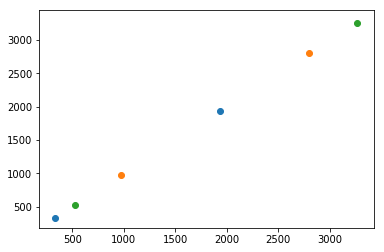

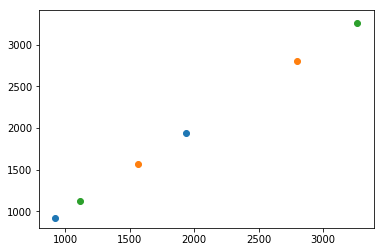

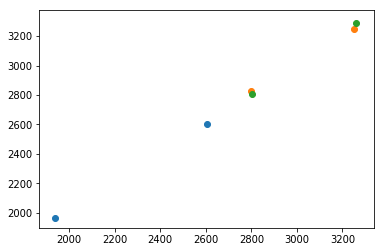

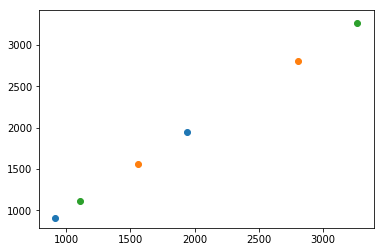

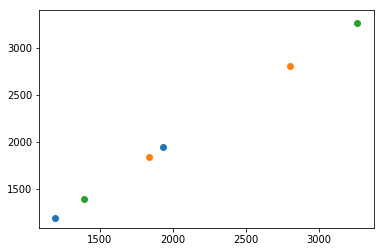

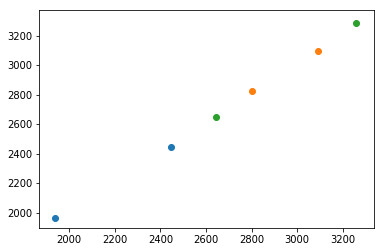

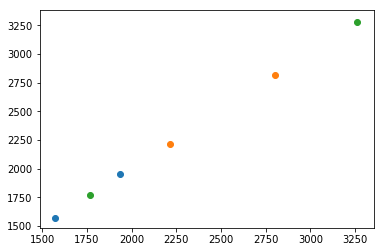

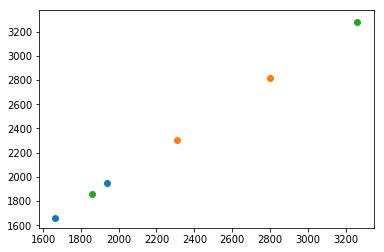

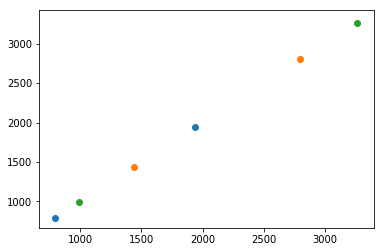

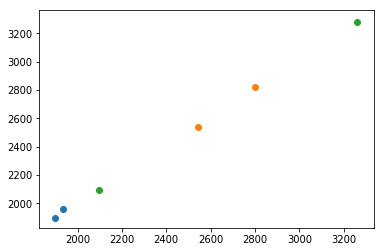

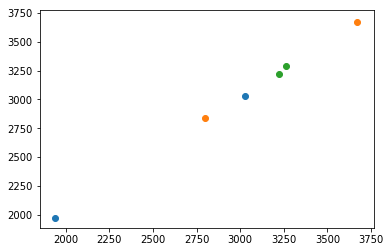

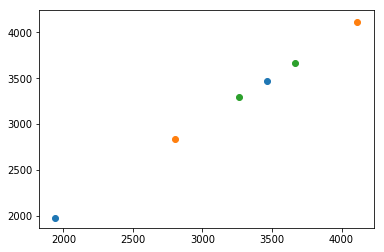

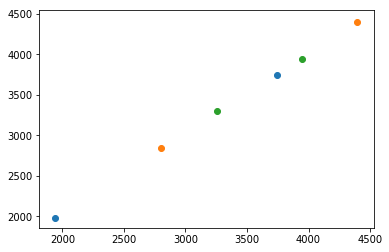

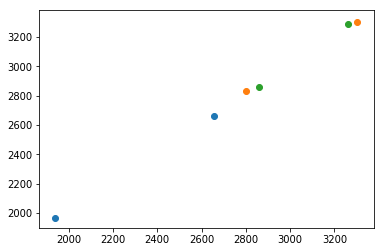

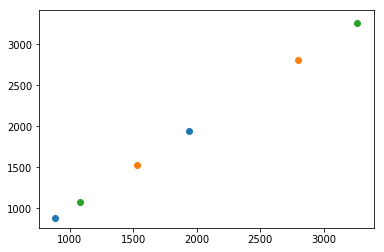

In [63]:
#colours = ['k','']
for x in range(len(cr[2])):
    for y in cr[2][x]:
        plt.scatter(y[0],y[1])
    plt.show()

In [28]:
len(refmatch)

2

In [43]:
finalMatchDict[0]

{}

In [93]:
refd[0]

[0.0,
 590.10094461104711,
 2275.1031394254746,
 580.04846580033302,
 861.79380571610056,
 2116.9226638874293,
 1241.5407117547134,
 1331.6163209229037,
 461.39251510904467,
 1567.1078230539019,
 2695.5780046011728,
 3135.1615356268271,
 3417.0413020184892,
 2328.3947246556395,
 551.59888999751433]

In [ ]:
# still needs some work ...